# DATA2 -  FEATURE SELECTION - EXTERNAL TABLE LINKING - SAVE TO CSV FILES 

### Towards longitudinal and baseline diagnosis


**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20201110](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20201110) - result folder,
    1. [results/20201120/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20201110/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - main repo folder,

---

The latest changes (ver. 0.10):

    v 0.10
    1. Save/load cross-validation splits to the file
    
    v 0.09
    1. Added linking_faq() function.
    2. Typos...
    
*Created: 2021.02.26 / Updated: 2021.10.04*

---

#### IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
from sklearn.model_selection import StratifiedKFold

#### MCI MODULES

In [4]:
# our imports 
import mci_get as mget
import mci_info as minfo
import mci_preprocessing as mpre
import mci_balancing as mbal
import mci_linking as mlink
import mci_utils as mutils
import mci_freesurfer as mfs
#pd.set_option('display.max_columns', None)

#### GLOBAL VARIABLES

In [5]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Data folder
DATA_DIR = ROOT_DIR/'data/data2'
# FreeSurfer data folder 
DATA_DIR_FS = ROOT_DIR /'data/data2_FS'
# Results folder
RESULTS_DIR = ROOT_DIR/'results'
#RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### NUMBER OF CSV FILES IN DATA2 FOLDER

In [6]:
# check number of files in data2 dir
!ls $DATA_DIR  | wc -l

359


#### INSTALLED PACKAGES INFO

In [7]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels', 'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: mk-prec-7540
Operating system: Linux, 64bit

Python path: /home/marek/miniconda3/envs/mci/bin/python
Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]



,module,version
4,eli5,0.11.0
6,ipywidgets,7.6.5
10,matplotlib,3.4.2
12,numpy,1.21.2
14,pandas,1.3.4
15,pdpbox,0.2.1
19,scipy,1.7.1
20,seaborn,0.11.2
22,sklearn,1.0
23,statsmodels,0.13.0


---

### ALGORITHM FLOWCHART

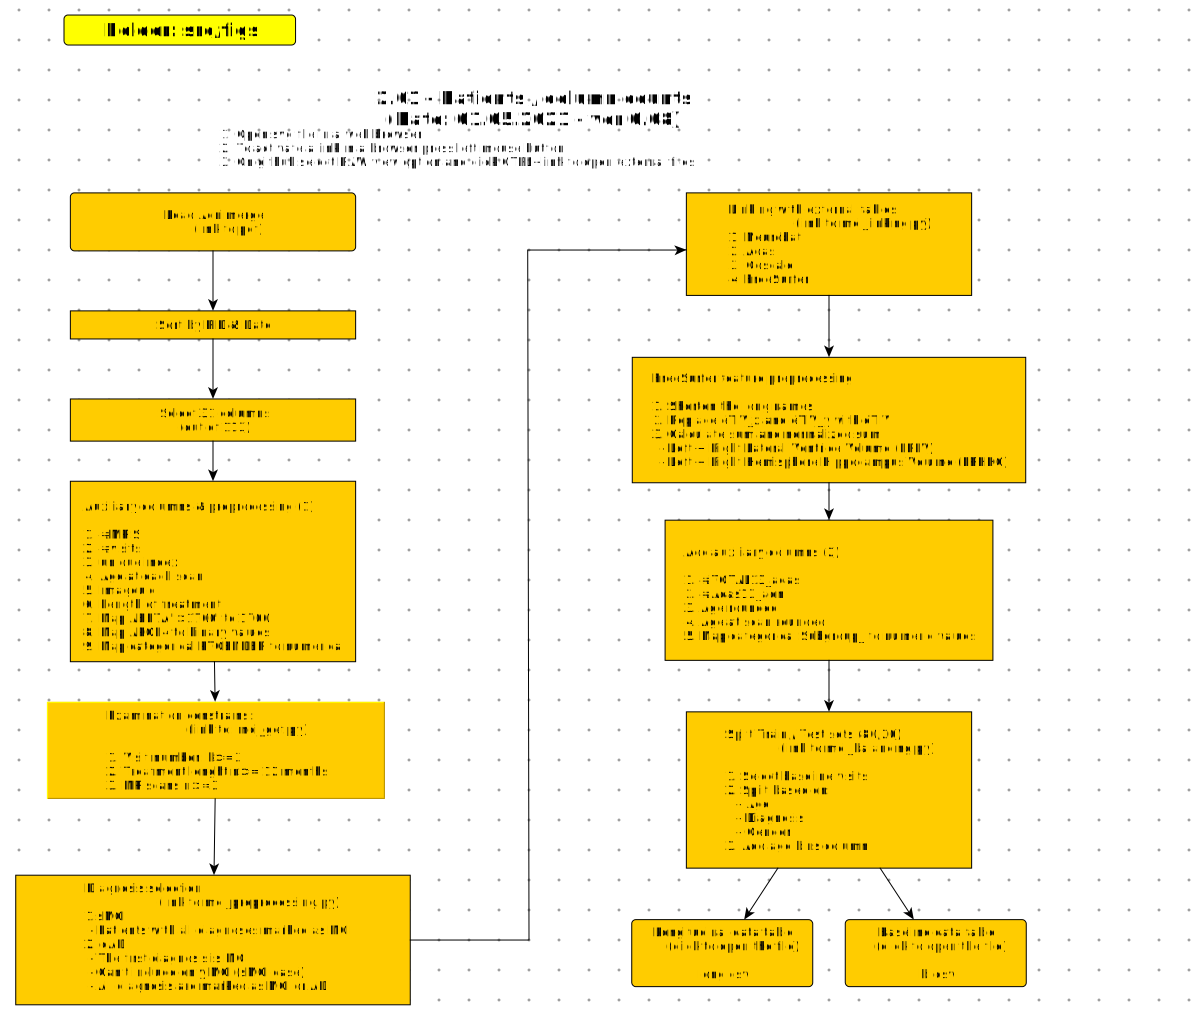

In [8]:
from IPython.display import SVG
SVG(filename='figs/2.01_preprocessing.svg')

### CODNING CATEGORICAL DATA TO NUMERIC VALUES 

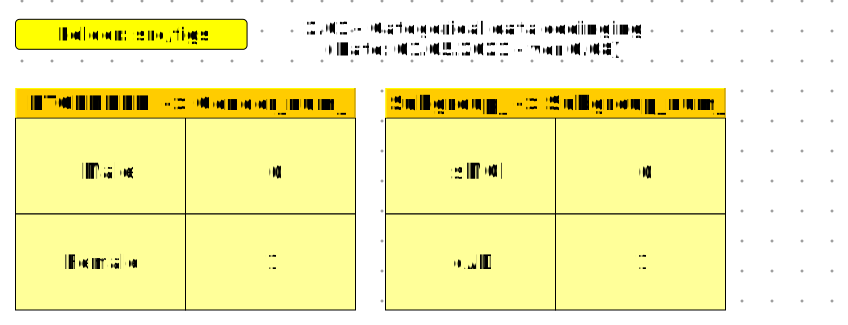

In [9]:
from IPython.display import SVG
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

---

### LOAD `ADNIMERGE` FILE

In [10]:
merge = pd.read_csv(DATA_DIR/'ADNIMERGE.csv', low_memory=False)

### SORT BY RID & DATE

In [11]:
# sort adnimerge file in descending RID & EXAMDATE
merge = merge.sort_values(by=['RID', 'EXAMDATE'])
rows_tot = merge.shape[0]
minfo.df_info(merge, 0, "Loaded adnimerge")

LOADED ADNIMERGE:
	Rows(exams): 15003,
	Columns (features): 113,
	Patients number (unique RID): 2282,
		Patients with at least one MRI image (MRIs): 0,
		Patients without any MRI image (MRIs): 0,
	MRI images (IMAGEUID): 8218.




In [12]:
minfo.df_info2(merge,"ADNIMERGE")

ADNIMERGE... done




,ADNIMERGE
Rows (exams),15003
Cols. (features),113
All patientes (unique RID),2282
Patients with at least one MR img (MRIs),0
Patients without MR imags (MRIs),0
MRI images (IMAGEUID),8218


---

# SELECT COLUMNS FROM ADNIMERGE FOR FURTHER PROCESSING

### 1. COLUMN SELECTION FROM ADNIMERGE

In [13]:
col1 = ['RID','PTID','PTGENDER','AGE','PTEDUCAT','EXAMDATE','Years_bl','Month','Month_bl'] 
col2 = ['VISCODE',  'DX', 'DX_bl'] 
col3 = ['ORIGPROT','COLPROT', 'IMAGEUID']
col4 = ['APOE4', 'ADAS13', 'TRABSCOR']
col5 = ['RAVLT_perc_forgetting', 'RAVLT_immediate','RAVLT_learning', 'RAVLT_forgetting']

# for baseline 
col6 = ['ABETA', 'PTAU', 'TAU'] # csf
col7 = ['PTETHCAT', 'PTRACCAT'] # race
col8 = ['MMSE', 'CDRSB','LDELTOTAL', 'FAQ'] # diagno

# this is a list of columns to select our of the whole adnimerge
long_col = col1 + col2 + col3 + col4 + col5 + col6 + col7 + col8

### 2. REDUCED TABLE TO SELECTED COLUMNS

In [14]:
long = merge[long_col].copy()

print(long.shape)
print()
print(long.columns)

(15003, 31)

Index(['RID', 'PTID', 'PTGENDER', 'AGE', 'PTEDUCAT', 'EXAMDATE', 'Years_bl',
       'Month', 'Month_bl', 'VISCODE', 'DX', 'DX_bl', 'ORIGPROT', 'COLPROT',
       'IMAGEUID', 'APOE4', 'ADAS13', 'TRABSCOR', 'RAVLT_perc_forgetting',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'ABETA',
       'PTAU', 'TAU', 'PTETHCAT', 'PTRACCAT', 'MMSE', 'CDRSB', 'LDELTOTAL',
       'FAQ'],
      dtype='object')


In [15]:
#minfo.iterate_patient_GUI(long[long_col])

In [16]:
#long.head()

### 3. COLUMN RENAMING

**NAMING CONVENTION:** All columns with underscore ("\_") suffix are added (calculated, assessed) by us.

In [17]:
long = long.rename({'COLPROT':'Phase',
                    'VISCODE':'VISCODE3_',
                    'TRABSCOR':'TRABSCOR_adni',
                    'ADAS13':'ADAS13_adni'}, axis='columns')
print(long.columns)

Index(['RID', 'PTID', 'PTGENDER', 'AGE', 'PTEDUCAT', 'EXAMDATE', 'Years_bl',
       'Month', 'Month_bl', 'VISCODE3_', 'DX', 'DX_bl', 'ORIGPROT', 'Phase',
       'IMAGEUID', 'APOE4', 'ADAS13_adni', 'TRABSCOR_adni',
       'RAVLT_perc_forgetting', 'RAVLT_immediate', 'RAVLT_learning',
       'RAVLT_forgetting', 'ABETA', 'PTAU', 'TAU', 'PTETHCAT', 'PTRACCAT',
       'MMSE', 'CDRSB', 'LDELTOTAL', 'FAQ'],
      dtype='object')


In [18]:
#long.head(2)

### 3. SUMMARY

In [19]:
minfo.df_info2(long, 'long', True)

long... done




,long
Rows (exams),15003
Cols. (features),31
All patientes (unique RID),2282
Patients with at least one MR img (MRIs),0
Patients without MR imags (MRIs),0
MRI images (IMAGEUID),8218


---

# AUXILIARY COLUMNS (Part 1)

### 1. NUMBER OF MRI IMAGES FOR EACH PATIENTS

As not all examinations contains corresponding images, we add a new column (named **MRIs**) with a total number of MRI images for each patient.

In [20]:
long = mpre.count_MR_images_for_patient(long, 'long', True)

A new column "MRIs_Nr_" is added to "long" table.


### 2. VISIT NUMBER FOR EACH PATIENT

We count a number of visits per patient, the result is stored in  **Visits\_Nr\_** column.

In [21]:
#%%time
long = mpre.count_visits_for_patient(long, 'long', True)

A new column "Visits_Nr_" is added to "long" table.


### 3. COLUMN WITH ADDITIONAL INDEX

It is kind of unique identifier for each subjec, an unique number independent from the df index. It can identify the patient at each level of the algorithm.

In [22]:
long['Idx_'] = range(long.shape[0])

### 4. AGE AT EACH SCAN

**Remark:** In previous files this colum was named as "Exam_Age"

In [23]:
long['Age_at_scan_'] = long['AGE'].values + long['Years_bl'].values

### 5. PREFIX "IMAGEUID" COLUMN WITH "I" LETTER

For compability with the image names in the ADNI database and FS result table.

In [24]:
long['Imageuid_'] = long['IMAGEUID'].apply(lambda x: 'I'+str(int(x)) if np.isfinite(x) else x)

### 6. LENGTH OF TREATMENT

This is the last value from the column 'Years\_bl'. It represents time in years (float value) since the baseline examination.

In [25]:
for r in long.RID.unique():
    pat = long.loc[long.RID == r]
    long.loc[long.RID == r, 'Participation_length_yr_'] = pat.Years_bl.to_numpy()[-1]

### 7. REPLACE STR VALUES IN "ABETA" MEASURE TO NUMERIC

Some "ABETA" values are represented by strings: **">1700"**. We replace those values with a number equalled to 1700 in a new column named "ABETA_"

In [26]:
long['Abeta_'] = long['ABETA'].apply(lambda x: 1700 if x=='>1700' else x)

### 8. REPLACE APOE4 WITH BINARY VALUES

Replace values bigger / equalled to "1" {1,2} with "1".

In [27]:
long['Apoe4_'] = long['APOE4'].apply(lambda x: 1 if x >= 1 else x)

### 9. MAP CATEGORICAL GENDER DESCRIPTION TO NUMERIC VALUES

In [28]:
long['Gender_num_'] = long['PTGENDER'].map({'Female': 1, 'Male': 0}).astype(int)

### 10. SUMMARY

In [29]:
minfo.df_info2(long, 'long', sh=False)

,long
Rows (exams),15003
Cols. (features),40
All patientes (unique RID),2282
Patients with at least one MR img (MRIs),1739
Patients without MR imags (MRIs),543
MRI images (IMAGEUID),8218


---

# CONSTRAINS

### 1. PATIENTS WITH MORE THAN / EQUALLED TO k>=3 VISITS

In [30]:
long_vis3 = mget.get_patient_with_more_equalled_k_visits(long, k=3)

### 2. PATIENTS WITH TREATMENT LONGER THAN / EQUALLED TO 12 MONTHS

In [31]:
long_vis3_12 = mget.get_patient_with_more_equalled_n_months(long_vis3, n=12)

### 3. PATIENTS WITH MORE THAN / EQUALLED TO 3 MRI IMAGES

In [32]:
long_vis3_12_mri3 = long.loc[long.MRIs_Nr_ >= 3]

### 4. SUMMARY / COMPARISION

In [33]:
dfs = [merge, long_vis3, long_vis3_12, long_vis3_12_mri3]
names = ['merge', 'long_vis3', 'long_vis3_12', 'long_vis3_12_mri3']

In [34]:
minfo.df_info2(dfs, names, sh=False)

,merge,long_vis3,long_vis3_12,long_vis3_12_mri3
Rows (exams),15003,14253,14193,13063
Cols. (features),113,40,40,40
All patientes (unique RID),2282,1797,1777,1486
Patients with at least one MR img (MRIs),0,1594,1574,1486
Patients without MR imags (MRIs),0,203,203,0
MRI images (IMAGEUID),8218,8021,7969,7823


---

# sMCI & cAD PATIENT IDENTIFICATION

### sMCI - ONLY MCI (INCLUDING NAN)

To find patients with all MCI diagnosis we'll temporarly drop examinations without diagnosis.

1. Remove patients with empty (NaN) diagnoses (DX)
1. Get patient RIDs that meet all diagnoses marked as MCI
1. Extract all examinations (including NaN) for patients (RIDs) from the table vis3_long 

REMARK: It happens that NaN values appears at the beginning or at the end of treatment

### cAD - MCI THAT HIT AD AT LEAST ONCE

1. Remove patients with empty (NaN) diagnoses (DX)
1. Get patient RIDs that meet all following conditions:
    - Starts with MCI 
    - Not contains MCI in each diagnosis (sMCI case - previous slide)
    - All examination diagnoses are MCI or AD
1. Extract all examinations (including NaN) for acquired patients (RIDs) from the table vis3_long 


REMARK: It happens that NaN values appears at the beginning or at the end of treatment

### 1. EXTRACTION OF THE SUBTABLE WITH sMCI & cAD PATIENTS

In [35]:
long = mpre.count_sMCI_cAD(long_vis3_12_mri3)

### 2. SPLIT BETWEEN sMCI & cAD 

This is done just to check te patient number in each subgroup. 

In [36]:
sMCI = long.loc[long.Subgroup_ == 'sMCI']
cAD = long.loc[long.Subgroup_ == 'cAD']

### 3. SUMMARY / COMPARISON

In [37]:
dfs = [merge, long_vis3_12_mri3, long, sMCI, cAD ]
names = ['merge','long_vis3_12_mri3', 'long (both sMCI &cAD)', 'sMCI', 'cAD']
minfo.df_info2(dfs, names, sh=False)

,merge,long_vis3_12_mri3,long (both sMCI &cAD),sMCI,cAD
Rows (exams),15003,13063,6333,3227,3106
Cols. (features),113,40,41,41,41
All patientes (unique RID),2282,1486,708,381,327
Patients with at least one MR img (MRIs),0,1486,708,381,327
Patients without MR imags (MRIs),0,0,0,0,0
MRI images (IMAGEUID),8218,7823,3943,2030,1913


In [38]:
#long.columns

In [39]:
# cols = ['RID','EXAMDATE','VISCODE3_', 'Month','DX', 'Visits_Nr_', 'MRIs_Nr_', 'Subgroup_', 'Idx_']
# minfo.iterate_patient_GUI(long[cols], name='long',sh=True)

---

# LINKING WITH EXTERNAL DATAFRAMES

In [40]:
long.shape

(6333, 41)

### NEUROBAT

In [41]:
long = mlink.link_neurobat(long, DATA_DIR)
long.shape

(6327, 55)

In [42]:
#[c for c in long.columns if c.endswith('_neuro')]

### ADAS

In [43]:
long = mlink.link_adas(long, DATA_DIR)
long.shape

(6327, 71)

In [44]:
#[c for c in long.columns if c.endswith('_adas')]

In [45]:
#[c for c in long.columns if 'adas' in c.lower()]

### GDSCALE

In [46]:
long = mlink.link_gdscale(long, DATA_DIR)
long.shape

(6327, 76)

In [47]:
#[c for c in long.columns if c.endswith('_gds')]

### FAQ

In [48]:
long = mlink.link_faq(long, DATA_DIR)
long.shape

(6327, 93)

In [49]:
#[c for c in long.columns if c.endswith('_faq')]

### FREESURFER

In [50]:
current_FS_result_file_name = '210405-all-stats.csv'

In [51]:
# #### test lines
# fs_name = DATA_DIR_FS / current_FS_result_file_name
# xxx = pd.read_csv(fs_name)

In [52]:
long = mlink.link_freesurfer(long, DATA_DIR_FS, current_FS_result_file_name)
long.shape

(6327, 108)

### FREESURFER FEATURE PROCESSING

In [53]:
long = mfs.shorten_FS_long_names(long, verbose=True)
long = mfs.compare_eTIV_x_and_eTIV_y(long, verbose=False)
long = mfs.calculate_sum_of_vetricle_volumes(long, verbose=False)
long = mfs.calculate_sum_of_hippocampus_volumes(long, verbose=False)

Rename the following column names:

	Left-Lateral-Ventricle-long ---> LLV_long
	Right-Lateral-Ventricle_long ---> RLV_long
	Left-Lateral-Ventricle_cross ---> LLV_cross
	Right-Lateral-Ventricle_cross ---> RLV_cross

	Left-Hippocampus_cross ---> LHHC_cross
	Right-Hippocampus_cross ---> RHHC_cross
	Left-Hippocampus_long ---> LHHC_long
	Right-Hippocampus_long ---> RHHC_long


### SUMMARY / COMPARISION

In [54]:
minfo.df_info2(long, 'long')

long... done




,long
Rows (exams),6327
Cols. (features),114
All patientes (unique RID),708
Patients with at least one MR img (MRIs),708
Patients without MR imags (MRIs),0
MRI images (IMAGEUID),3943


In [55]:
minfo.included_feature_info(long, pattern='adas-neuro-gds-faq-long-cross-_')

Total number of columns: 114



,adas (#16),neuro (#14),gds (#5),faq (#17),long (#10),cross (#10),ours (#12)
0,MERGE_long_adas,ANARTERR_neuro,EXAMDATE_gds,EXAMDATE_faq,LHHC_long,LHHC_cross,Abeta_
1,Q10_adas,AVDEL30MIN_neuro,GDTOTAL_gds,FAQBEVG_faq,LLV_long,LLV_cross,Age_at_scan_
2,Q11_adas,AVDELTOT_neuro,MERGE_long_gds,FAQEVENT_faq,LRHHC_long,LRHHC_cross,Apoe4_
3,Q12_adas,AVTOT6_neuro,Phase_gds,FAQFINAN_faq,LRHHC_n_long,LRHHC_n_cross,Gender_num_
4,Q13_adas,AVTOTB_neuro,VISCODE2_gds,FAQFORM_faq,LRLV_long,LRLV_cross,Idx_
5,Q1_adas,CATANIMSC_neuro,,FAQGAME_faq,LRLV_n_long,LRLV_n_cross,Imageuid_
6,Q2_adas,CLOCKSCOR_neuro,,FAQMEAL_faq,RHHC_long,RHHC_cross,MERGE_FS_
7,Q3_adas,COPYSCOR_neuro,,FAQREM_faq,RLV_long,RLV_cross,MRIs_Nr_
8,Q4_adas,EXAMDATE_neuro,,FAQSHOP_faq,complete_long,complete_cross,Participation_length_yr_
9,Q5_adas,MERGE_long_neuro,,FAQSOURCE_faq,eTIV_long,eTIV_cross,Subgroup_


---

# AUXILIARY COLUMNS (Part 2)

### 1. NUMBER OF TOTAL13_adas & ADAS13_adni for each patient

These functions should be updated according to each score protocol. Before assessing the number of scors, we should check if the score was measured during every patient visits!

In [56]:
long = mpre.count_score_nr_for_patient(long, 'TOTAL13_adas', 'TOTAL13_adas_Nr_', df_name='long', sh=1)
long = mpre.count_score_nr_for_patient(long, 'ADAS13_adni', 'ADAS13_adni_Nr_', df_name='long', sh=1)

A new column "TOTAL13_adas_Nr_" is added to "long" table.
A new column "ADAS13_adni_Nr_" is added to "long" table.


### 2. ROUNDED AGE TO INTEGER VALUES

This column is added here, in the part (Part 2), because there exists some `np.NaN` values in the `long` table that contains all subjects. Those `np.NaN` values make it impossible to set `int` type of the column. This is the only reason why `Age_rounded_` is not prpeared earlier (in the Part 1).

In [57]:
long['Age_rounded_'] = long['Age_at_scan_'].apply(lambda x: int(round(x,0)) if np.isfinite(x) else x)
long['Age_rounded_'] = long.Age_rounded_.astype(int)

### 3. AGE AT EACH SCAN ROUNDED TO INT VALUE

In [58]:
long['Age_at_scan_rounded_'] = long['Age_at_scan_'].apply(lambda x: int(round(x,0)) if np.isfinite(x) else x)
long['Age_at_scan_rounded_'] = long.Age_at_scan_rounded_.astype(int)

### 4. MAP CATEGORICAL `SUBGROUP_` VALUES TO NUMBERS

In [59]:
long['Subgroup_num_'] = long['Subgroup_'].map({'cAD': 1, 'sMCI': 0}).astype(int)

In [60]:
# cols = ['RID','EXAMDATE','VISCODE3_', 'Month','DX', 'Subgroup_', 'Subgroup_num_']
# minfo.iterate_patient_GUI(long[cols], sh=1)

### 5. FAQ: POSITIVE/NEGATIVE CLASSIFICATION CRITERIA

In [61]:
long = mpre.faq_pos_neg_classification(long)

A new column "FAQFINAN_faq_cod_" is added to "long" table.
A new column "FAQFORM_faq_cod_" is added to "long" table.
A new column "FAQSHOP_faq_cod_" is added to "long" table.
A new column "FAQGAME_faq_cod_" is added to "long" table.
A new column "FAQBEVG_faq_cod_" is added to "long" table.
A new column "FAQMEAL_faq_cod_" is added to "long" table.
A new column "FAQEVENT_faq_cod_" is added to "long" table.
A new column "FAQTV_faq_cod_" is added to "long" table.
A new column "FAQREM_faq_cod_" is added to "long" table.
A new column "FAQTRAVL_faq_cod_" is added to "long" table.
A new column "Faq_cnts_" is added to "long" table.
A new column "Faq_dsc_" is added to "long" table.


### 6. SUMMARY / COMPARISION

In [62]:
minfo.df_info2(long,'long')

long... done




,long
Rows (exams),6327
Cols. (features),131
All patientes (unique RID),708
Patients with at least one MR img (MRIs),708
Patients without MR imags (MRIs),0
MRI images (IMAGEUID),3943


In [63]:
#long.columns

In [63]:
minfo.included_feature_info(long, pattern='adas-neuro-gds-faq-cross-long-_')

Total number of columns: 131



,adas (#16),neuro (#14),gds (#5),faq (#17),long (#10),cross (#10),ours (#29)
0,MERGE_long_adas,ANARTERR_neuro,EXAMDATE_gds,EXAMDATE_faq,LHHC_long,LHHC_cross,ADAS13_adni_Nr_
1,Q10_adas,AVDEL30MIN_neuro,GDTOTAL_gds,FAQBEVG_faq,LLV_long,LLV_cross,Abeta_
2,Q11_adas,AVDELTOT_neuro,MERGE_long_gds,FAQEVENT_faq,LRHHC_long,LRHHC_cross,Age_at_scan_
3,Q12_adas,AVTOT6_neuro,Phase_gds,FAQFINAN_faq,LRHHC_n_long,LRHHC_n_cross,Age_at_scan_rounded_
4,Q13_adas,AVTOTB_neuro,VISCODE2_gds,FAQFORM_faq,LRLV_long,LRLV_cross,Age_rounded_
5,Q1_adas,CATANIMSC_neuro,,FAQGAME_faq,LRLV_n_long,LRLV_n_cross,Apoe4_
6,Q2_adas,CLOCKSCOR_neuro,,FAQMEAL_faq,RHHC_long,RHHC_cross,FAQBEVG_faq_cod_
7,Q3_adas,COPYSCOR_neuro,,FAQREM_faq,RLV_long,RLV_cross,FAQEVENT_faq_cod_
8,Q4_adas,EXAMDATE_neuro,,FAQSHOP_faq,complete_long,complete_cross,FAQFINAN_faq_cod_
9,Q5_adas,MERGE_long_neuro,,FAQSOURCE_faq,eTIV_long,eTIV_cross,FAQFORM_faq_cod_


---

# TRAIN / TEST DATA SETS

To split data betwen `train` and `test` sets based on selected cohort features like: AGE, diagnosis, gender, we use a subset of the `long` table that contains a single presence of each patient. Such a table might be created with `baseline` visits.  

### 1. BASELINE VISITS

In [64]:
# bl = mget.get_patient_nth_examination(long,0)
bl = long.loc[long.VISCODE3_ == 'bl'].copy()

#### REMARK


Some values are rewritten from the **long** table, so they don't correspond to the current content ot the **bl**  table:
 - MRIs_Nr_,
 - TOTAL13_adas_Nr_,
 - ADAS13_adni_Nr_.

In [65]:
#bl.head(10)

In [66]:
# cols = ['RID','EXAMDATE','VISCODE3_','Month','DX','Visits_Nr_','MRIs_Nr_',
#         'Subgroup_','AGE','Age_rounded_','Treatment_length_', 'TOTAL13_adas_Nr_','ADAS13_adni_Nr_']
# minfo.iterate_patient_GUI(bl[cols], sh=1)

### 2. SUMMARY / COMPARISON

In [67]:
dfs = [long, bl,]
names = ['long', 'bl']
minfo.df_info2(dfs, names, sh=False)

,long,bl
Rows (exams),6327,708
Cols. (features),131,131
All patientes (unique RID),708,708
Patients with at least one MR img (MRIs),708,708
Patients without MR imags (MRIs),0,0
MRI images (IMAGEUID),3943,706


---

### TRAIN / TEST SPLIT PROCEDURE

Taking into account a cohort age bins, diagnosis and gender we split the subjects from `bl` table into `training` and `test` sets. Each patient is afilliated with Train or Test flag in the newly created `Usage_` column.  

In [68]:
bl = mbal.train_test_split_baseline(bl, age_bins=[50,60,70,80,95], split_categories=['Age_bin_', 'Subgroup_', 'PTGENDER'],
                                    test_size=0.2, random_state=42, df_name='bl', sh=True)

A new column "Age_bin_" is added to the "bl" table
A new column "Usage_" is added to the "bl" table


### GET TRAIN / TEST SUBTABLES FROM `BL`

In [69]:
# Get train and test sets (to identify the subject's RID)
train_set = bl.loc[bl.Usage_ == 'train']
test_set = bl.loc[bl.Usage_ == 'test'] 

### ASSIGN `LONG` TABLE SUBJECTS TO TRAIN/TEST SETS

In [70]:
# 1. Mark train and test sets inside all long table examinations - with the use of RID
# 2. Add column 'Usage_' to the long table
long.loc[long.RID.isin(train_set.RID), 'Usage_'] = 'train'
long.loc[long.RID.isin(test_set.RID), 'Usage_'] = 'test'

### UPDATE AGE BINS IN `LONG` FROM `BL`

In [71]:
# Create column 'Age_bin_' in the long table and fill it in with values from bl table 
for r in bl.RID.unique():
    long.loc[long.RID == r, 'Age_bin_'] = bl[bl.RID==r]['Age_bin_'].values[0]

### SUMMARY / COMPARISION

In [72]:
#long.head()

In [73]:
# cols = ['RID', 'VISCODE3_', 'Age_rounded_', 'Age_bin_', 'Usage_' ]
# minfo.iterate_patient_GUI(long[cols])

In [74]:
train_set = long[long.Usage_=='train']
test_set = long[long.Usage_=='test']
minfo.df_info2([train_set, test_set, long], ['train_set', 'test_set', 'long'])

train_set... done
test_set... done
long... done




,train_set,test_set,long
Rows (exams),5021,1306,6327
Cols. (features),133,133,133
All patientes (unique RID),566,142,708
Patients with at least one MR img (MRIs),566,142,708
Patients without MR imags (MRIs),0,0,0
MRI images (IMAGEUID),3135,808,3943


---

# SUMMARY

In [75]:
minfo.df_info2(long, 'long')

long... done




,long
Rows (exams),6327
Cols. (features),133
All patientes (unique RID),708
Patients with at least one MR img (MRIs),708
Patients without MR imags (MRIs),0
MRI images (IMAGEUID),3943


In [76]:
minfo.included_feature_info(long, pattern='adni-adas-neuro-gds-cross-long-faq_')

Total number of columns: 133



,adni (#30),adas (#16),neuro (#14),gds (#5),faq (#17),long (#10),cross (#10),ours (#31)
0,ABETA,MERGE_long_adas,ANARTERR_neuro,EXAMDATE_gds,EXAMDATE_faq,LHHC_long,LHHC_cross,ADAS13_adni_Nr_
1,ADAS13_adni,Q10_adas,AVDEL30MIN_neuro,GDTOTAL_gds,FAQBEVG_faq,LLV_long,LLV_cross,Abeta_
2,AGE,Q11_adas,AVDELTOT_neuro,MERGE_long_gds,FAQEVENT_faq,LRHHC_long,LRHHC_cross,Age_at_scan_
3,APOE4,Q12_adas,AVTOT6_neuro,Phase_gds,FAQFINAN_faq,LRHHC_n_long,LRHHC_n_cross,Age_at_scan_rounded_
4,CDRSB,Q13_adas,AVTOTB_neuro,VISCODE2_gds,FAQFORM_faq,LRLV_long,LRLV_cross,Age_bin_
5,DX,Q1_adas,CATANIMSC_neuro,,FAQGAME_faq,LRLV_n_long,LRLV_n_cross,Age_rounded_
6,DX_bl,Q2_adas,CLOCKSCOR_neuro,,FAQMEAL_faq,RHHC_long,RHHC_cross,Apoe4_
7,EXAMDATE,Q3_adas,COPYSCOR_neuro,,FAQREM_faq,RLV_long,RLV_cross,FAQBEVG_faq_cod_
8,FAQ,Q4_adas,EXAMDATE_neuro,,FAQSHOP_faq,complete_long,complete_cross,FAQEVENT_faq_cod_
9,IMAGEUID,Q5_adas,MERGE_long_neuro,,FAQSOURCE_faq,eTIV_long,eTIV_cross,FAQFINAN_faq_cod_


---

### INTERACTIVE INSPECTION THE FINAL TABLE WITH SELECTED SUBJECTS

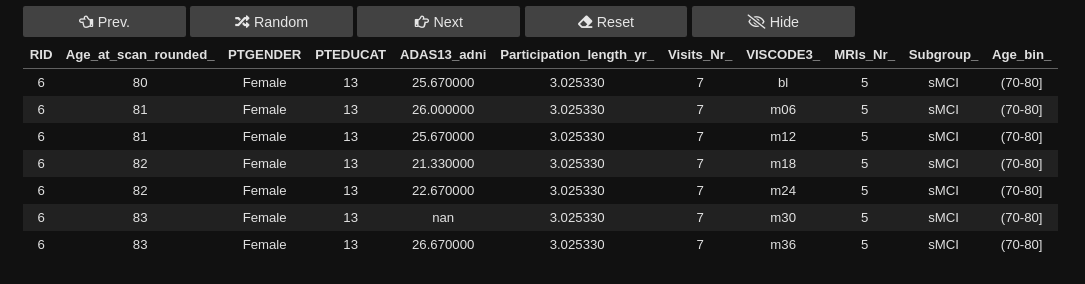

In [78]:
cols = ['RID', 'Age_at_scan_rounded_','PTGENDER','PTEDUCAT', 'ADAS13_adni', 'Participation_length_yr_', 'Visits_Nr_',
        'VISCODE3_', 'MRIs_Nr_', 'Subgroup_', 'Age_bin_']
minfo.iterate_patient_GUI(long[cols])

---

# SAVE `long` & `bl` TABLES TO A RESULTS FOLDER

#### GROUP AND SORT COLUMN NAMES BY TYPE 

In [79]:
long = mpre.reorder_columns(long, verbose=True)

Columns in and out are the same!
Columns in 133, out 133


In [80]:
bl = mpre.reorder_columns(bl, verbose=True)

Columns in and out are the same!
Columns in 133, out 133


#### SAVE TO RESULT FOLDER

In [81]:
save_main = 0
if save_main:
    results = RESULTS_DIR / '20201110'

    baseline_name = results / 'bl.csv'
    long_name = results / 'long.csv'

    bl.sort_values(by=['RID'], inplace=True)
    bl.to_csv(baseline_name, index=True)
    long.to_csv(long_name, index=True)
    
    ####  to read these files use commands:
    #bl = pd.read_csv(baseline_name, index_col=0)
    #cMCI_cAD = pd.read_csv(sMCI_cAD_name, index_col=0)

---

# SELECT PATIENT (PTID) AND IMAGE (IMAGEUID) IDs 

In [82]:
pat_info = long.dropna(subset = ["IMAGEUID"]).copy()
pat_info = pat_info[['RID','PTID', 'IMAGEUID']]
pat_info['IMAGEUID'] = pat_info.IMAGEUID.astype(int)

pat_info = pat_info.sort_values(by=['RID'])
pat_info = pat_info[['PTID', 'IMAGEUID']]
print(pat_info.shape)

(3943, 2)


### SAVE TO A DISK

In [83]:
save_aux = 0
if save_aux:
    results = RESULTS_DIR / '20201110'
    
    ptid_name = results / 'sMCI_cAD_PTID.txt'
    pat_info.to_csv(ptid_name, index=False, header=False)

### ALGORITHM SUMMARY

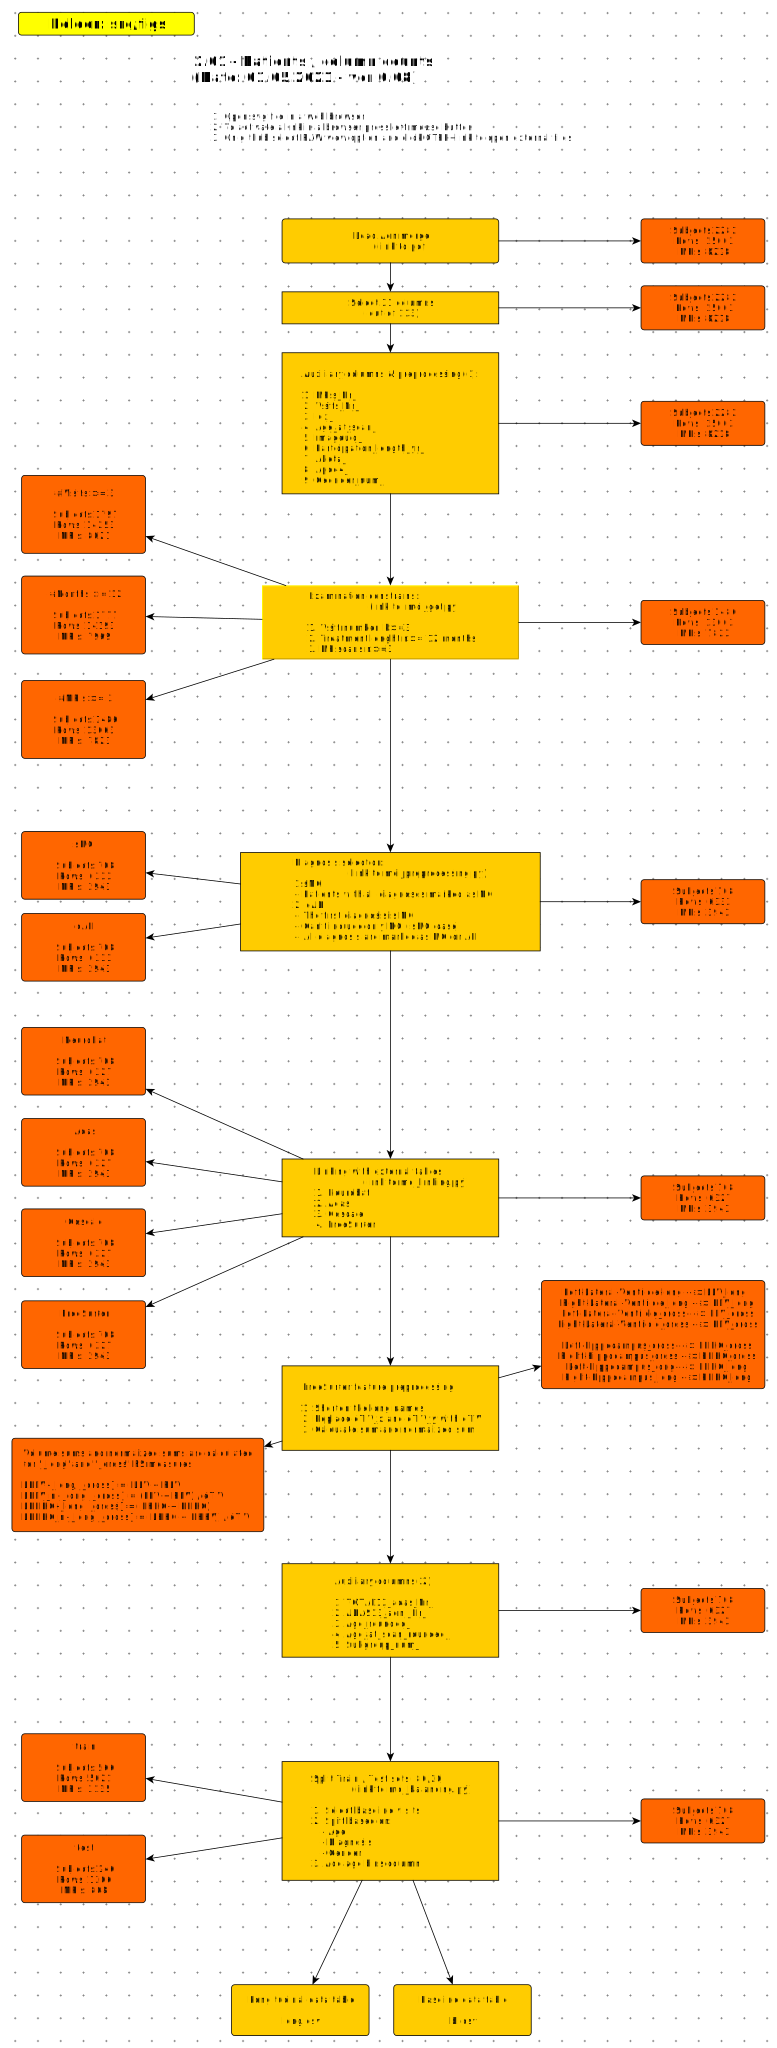

In [84]:
from IPython.display import SVG
SVG(filename='figs/2.01_preprocessing_patients.svg')

----